,graphst_cluster,banksy_cluster,n_G,n_B,TP,FN,FP,TN,precision,recall,f1,jaccard,%_of_G_recovered,%_of_B_shared,fisher_odds,fisher_p_two_sided
0,0,6,3000,3000,2381,619,619,5750,0.794,0.794,0.794,0.658,79.4,79.4,35.731,0.000e+00
1,1,2,3000,3000,1852,1148,1148,5221,0.617,0.617,0.617,0.446,61.7,61.7,7.337,0.000e+00
2,2,3,1631,3000,327,1304,2673,5065,0.109,0.200,0.141,0.076,20.0,10.9,0.475,5.098e-32
3,3,0,3000,3000,1244,1756,1756,4613,0.415,0.415,0.415,0.262,41.5,41.5,1.861,2.017e-40
4,4,5,3000,3000,969,2031,2031,4338,0.323,0.323,0.323,0.193,32.3,32.3,1.019,7.042e-01
5,5,4,3000,3000,1394,1606,1606,4763,0.465,0.465,0.465,0.303,46.5,46.5,2.574,1.484e-91
6,6,1,3000,3000,1010,1990,1990,4379,0.337,0.337,0.337,0.202,33.7,33.7,1.117,2.003e-02
7,7,7,3000,3000,1201,1799,1799,4570,0.400,0.400,0.400,0.250,40.0,40.0,1.696,1.317e-29



Saved summary to: C:\Users\suhas\results_overlap\overlap_summary.csv


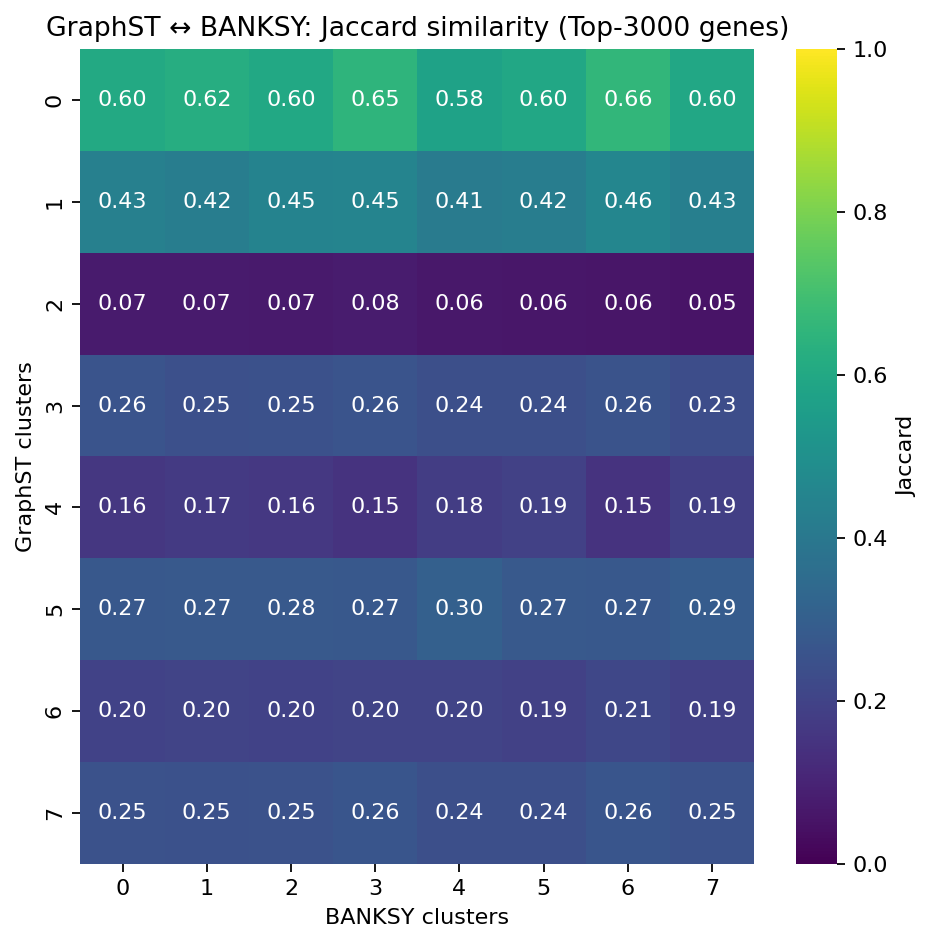

Saved heatmap to: C:\Users\suhas\results_overlap\jaccard_heatmap.png


In [2]:
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.optimize import linear_sum_assignment
from scipy.stats import fisher_exact

BANKSY_CSV  = r"C:\Users\suhas\Banksy_py\banksy_cluster_genes_per_cluster_long.csv"
GRAPHST_CSV = r"D:\Projects\GraphST\cluster_genes_per_cluster_long.csv"

# Column names in the CSVs
COL_CLUSTER = "cluster"
COL_GENE    = "gene"
COL_PVAL    = "pval_adj"    

TOP_N       = 3000          
AUTO_ALIGN  = True         
SAVE_DIR    = Path("results_overlap") 

UNIVERSE_MODE = "global"
# ----------------------------------------------------------------------------

# Helpers
_BIDI = re.compile(r'[\u200E\u200F\u202A-\u202E\u2066-\u2069]')
def _clean_path(s: str) -> str:
    return _BIDI.sub('', str(s)).strip()

def _norm_gene(x: str) -> str:
    return str(x).strip().upper()

def load_markers_long(path, col_cluster, col_gene, col_pval=None):
    """Load long markers CSV; return DataFrame with standardized columns [cluster, gene, pval (optional), rank]."""
    df = pd.read_csv(_clean_path(path))
    if col_cluster not in df.columns or col_gene not in df.columns:
        raise ValueError(f"CSV {path} must contain columns '{col_cluster}' and '{col_gene}'. Found: {df.columns.tolist()}")

    df = df[[col_cluster, col_gene] + ([col_pval] if (col_pval and col_pval in df.columns) else [])].copy()
    df[col_cluster] = df[col_cluster].astype(str)
    df[col_gene]    = df[col_gene].map(_norm_gene)

   
    if col_pval and col_pval in df.columns:
        df = df.sort_values([col_cluster, col_pval, col_gene], ascending=[True, True, True])
        df["rank"] = df.groupby(col_cluster).cumcount() + 1
    else:
        df["rank"] = df.groupby(col_cluster).cumcount() + 1
    return df

def topN_sets(df, n, col_cluster, col_gene):
    """Return dict: cluster -> set(top-N genes by 'rank')."""
    top = df[df["rank"] <= n]
    d = {k: set(v[col_gene].dropna().astype(str)) for k, v in top.groupby(col_cluster)}
    return d

def jaccard(A, B):
    if not A and not B:
        return 1.0
    if not A or not B:
        return 0.0
    inter = len(A & B)
    union = len(A | B)
    return inter / union if union else 0.0

def build_universe(b_sets, g_sets, mode="global"):
    if mode == "global":
        U = set().union(*b_sets.values(), *g_sets.values())
    elif mode == "banksy":
        U = set().union(*b_sets.values())
    elif mode == "graphst":
        U = set().union(*g_sets.values())
    else:
        raise ValueError("UNIVERSE_MODE must be one of: 'global', 'banksy', 'graphst'.")
    return U

def fisher_from_sets(G, B, U):
    """2x2 contingency on global universe U:
       [[TP, FN],
        [FP, TN]]  with
       TP = |G∩B|, FN = |G\B|, FP = |B\G|, TN = |U| - TP - FN - FP
    """
    TP = len(G & B)
    FN = len(G - B)
    FP = len(B - G)
    TN = len(U) - TP - FN - FP
    
    TN = max(TN, 0)
    table = np.array([[TP, FN],[FP, TN]], dtype=int)
    # two-sided Fisher
    odds, p = fisher_exact(table, alternative="two-sided")
    return TP, FN, FP, TN, odds, p, table


banksy_df  = load_markers_long(BANKSY_CSV,  COL_CLUSTER, COL_GENE, COL_PVAL)
graphst_df = load_markers_long(GRAPHST_CSV, COL_CLUSTER, COL_GENE, COL_PVAL)

b_sets = topN_sets(banksy_df,  TOP_N, COL_CLUSTER, COL_GENE)
g_sets = topN_sets(graphst_df, TOP_N, COL_CLUSTER, COL_GENE)

b_clusters = sorted(b_sets.keys(), key=lambda x: (len(x), x))
g_clusters = sorted(g_sets.keys(), key=lambda x: (len(x), x))


J = np.zeros((len(g_clusters), len(b_clusters)), dtype=float)
for i, gk in enumerate(g_clusters):
    for j, bk in enumerate(b_clusters):
        J[i, j] = jaccard(g_sets[gk], b_sets[bk])

if AUTO_ALIGN:
    
    cost = 1.0 - J
    row_ind, col_ind = linear_sum_assignment(cost)  # covers all rows (GraphST clusters)
    alignment = list(zip([g_clusters[i] for i in row_ind], [b_clusters[j] for j in col_ind]))
else:
  
    shared = sorted(set(g_clusters) & set(b_clusters))
    alignment = [(k, k) for k in shared]


U_global = build_universe(b_sets, g_sets, mode=UNIVERSE_MODE)


rows = []
for gk, bk in alignment:
    G = g_sets.get(gk, set())
    B = b_sets.get(bk, set())

    TP, FN, FP, TN, odds, p, table = fisher_from_sets(G, B, U_global)

    # derived metrics
    prec   = TP / (TP + FP) if (TP + FP) else 0.0
    rec    = TP / (TP + FN) if (TP + FN) else 0.0
    f1     = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0
    jac    = jaccard(G, B)
    cov_G  = TP / len(G) if len(G) else 0.0
    cov_B  = TP / len(B) if len(B) else 0.0

    rows.append({
        "graphst_cluster": gk,
        "banksy_cluster": bk,
        "n_G": len(G),
        "n_B": len(B),
        "TP": TP, "FN": FN, "FP": FP, "TN": TN,
        "precision": prec, "recall": rec, "f1": f1,
        "jaccard": jac,
        "%_of_G_recovered": 100*cov_G,
        "%_of_B_shared": 100*cov_B,
        "fisher_odds": odds,
        "fisher_p_two_sided": p
    })

summary = pd.DataFrame(rows).sort_values(["graphst_cluster"]).reset_index(drop=True)


SAVE_DIR.mkdir(parents=True, exist_ok=True)
summary_path = SAVE_DIR / "overlap_summary.csv"
summary.to_csv(summary_path, index=False)
display(summary.style.format({
    "precision": "{:.3f}", "recall": "{:.3f}", "f1": "{:.3f}",
    "jaccard": "{:.3f}", "%_of_G_recovered": "{:.1f}", "%_of_B_shared": "{:.1f}",
    "fisher_odds": "{:.3f}", "fisher_p_two_sided": "{:.3e}"
}))

print(f"\nSaved summary to: {summary_path.resolve()}")


plt.figure(figsize=(1.2+0.6*len(b_clusters), 1.2+0.6*len(g_clusters)), dpi=160)
ax = sns.heatmap(
    J, vmin=0, vmax=1, cmap="viridis", annot=True, fmt=".2f",
    xticklabels=b_clusters, yticklabels=g_clusters, cbar_kws={"label": "Jaccard"}
)
ax.set_xlabel("BANKSY clusters")
ax.set_ylabel("GraphST clusters")
ax.set_title("GraphST ↔ BANKSY: Jaccard similarity (Top-{} genes)".format(TOP_N))
plt.tight_layout()
heatmap_path = SAVE_DIR / "jaccard_heatmap.png"
plt.savefig(heatmap_path, bbox_inches="tight")
plt.show()
print(f"Saved heatmap to: {heatmap_path.resolve()}")


conf_dir = SAVE_DIR / "confusions"
conf_dir.mkdir(exist_ok=True, parents=True)

for r in rows:
    gk, bk = r["graphst_cluster"], r["banksy_cluster"]
    TP, FN, FP, TN = r["TP"], r["FN"], r["FP"], r["TN"]
    cm = np.array([[TP, FN], [FP, TN]], dtype=int)

    fig, ax = plt.subplots(figsize=(3.4, 3.1), dpi=180)
    im = ax.imshow(cm, cmap="Blues")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=11)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Present", "Absent"])
    ax.set_yticklabels(["Present", "Absent"])
    ax.set_xlabel("BANKSY"); ax.set_ylabel("GraphST")
    ax.set_title(f"Confusion: G={gk} vs B={bk}\nJ={r['jaccard']:.2f}, p(Fisher)={r['fisher_p_two_sided']:.1e}")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    outp = conf_dir / f"cm_G{gk}_B{bk}.png"
    plt.tight_layout()
    plt.savefig(outp, bbox_inches="tight")
    plt.close(fig)
# ============================================================================================
